#  Context : 

Le but de ce notebook est de mettre en place l'utilisation du texte résumé dans les notebook précédents pour essayer de faire la prédiction en symptomes.

La première étape est d'utiliser un TfIdf en guise de baseline afin d'obtenir des données utilisable par un algorithme pour la prédiction.

Cette étape de prédiction doit être couplée avec le package eli5 et nous ''oblige'' à passer par une voie multiclass et donc un modèle par symptomes à prédire, plutot qu'une voie multilabel-multioutputs qui utiliserait 1 modèle.

- baseline bruité
- sans le bruit
- etude N-gram

# Import : 

In [3]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

import eli5

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree, multilabel_multioutput_svc, multilabel_multioutput_LR, custom_show_weights

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nwolpert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# NLP 

## Load data : 

In [4]:
# Loading X : 
df_nlp = pd.read_csv('./../../Data/Generate/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
print('X shape is :', df_nlp.shape)

# Loading Y : 
recueil  = pd.read_excel('./../../Data/Raw/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil.replace(['Na', 'NA'], np.nan, inplace=True)
recueil.set_index('Numéro anonymat', inplace=True)
print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')

X shape is : (1137, 4)
Y shape is : (181, 89)
Nombre de patientes dans le df_nlp : 178


C:\Users\nwolpert\AppData\Local\Temp\ipykernel_17668\4160811754.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil.replace(['Na', 'NA'], np.nan, inplace=True)


In [8]:
if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'

In [9]:
'NJ-055' in list(df_nlp['Anonymisation'])

True

In [10]:
'DJ-055' in list(df_nlp['Anonymisation'])

False

## Preprocess 

In [1]:
# Préprocess les datas : 
X_train, X_test, Y_train, Y_test, max_vocab = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    'all',
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=True,      # supprime les caractères spéciaux  
                                                                    accents=True,           # supprime les accents
                                                                    lower=False,            # passe la casse du texte en minuscule
                                                                    token=False,            # tokenize le corpus
                                                                    remove_stopwords=False,
                                                                    drop_number=True,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True
                                                                  )
print(f'Nombre de patientes inclues dans l\'étude NLP "baseline" : {X_train.shape[0] + X_test.shape[0]}')
print(f'Nombre de symptômes/caractéristiques à prédire dans l\'étude NLP "baseline" : {Y_train.shape[1]}')

NameError: name 'preprocess_and_split' is not defined

In [24]:
X_train.head()

,Anonymisation,Résumé
136,HN-078,Auprès dun confrère radiologue IRM PELVIENNE ...
55,KN-079,pose ESSURE contexte hydrosalpinx pose clip un...
124,AE-060,Appel téléphonique patiernte moins douloureuse...
84,RS-061,Rectosonographie échographie pelvienne avec co...
105,VM-156,Rectosonographie échographie pelvienne avec co...


In [25]:
# Préprocess les datas : 
X_train_sw, X_test_sw, Y_train_sw, Y_test_sw, max_vocab_sw = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    'all',
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=True,      # supprime les caractères spéciaux  
                                                                    accents=True,    # supprime les accents
                                                                    lower=False,            # passe la casse du texte en minuscule
                                                                    token=True,            # tokenize le corpus
                                                                    remove_stopwords=True,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True
                                                                  )
print(f'Nombre de patientes inclues dans l\'étude NLP sans stopword : {X_train_sw.shape[0] + X_test_sw.shape[0]}')

Nombre de patientes inclues dans l'étude NLP sans stopword : 157


In [26]:
X_train_sw.head()

,Anonymisation,Résumé
136,HN-078,"[Auprès, dun, confrère, radiologue, , IRM, PEL..."
55,KN-079,"[pose, ESSURE, contexte, hydrosalpinx, pose, c..."
124,AE-060,"[Appel, téléphonique, patiernte, moins, doulou..."
84,RS-061,"[Rectosonographie, échographie, pelvienne, con..."
105,VM-156,"[Rectosonographie, échographie, pelvienne, con..."


In [15]:
### Rappel des classes : 
# 0 : Negatif 
# 1 : Positif
# 2 : Non mentionnées

### Guidelines de l'études : 
#1 baseline bruité
#2 sans le bruit
#3 etude N-gram

                                # ne pas prendre en compte les chiffres  

# >>> classe 1 precision rappel UNIQUEMENT 
# F1_score pour chaque label

#Classer du F1 score le + au -

# mot qui participe à la pred de la classe 1 pour chaque target (donc chaque colonne)
#eli5 package !!!! 

____

## TF-IDF


In [9]:
### avec stopwords

In [16]:
#max_vocab = 25000
tfIdfVectorizer=TfidfVectorizer(use_idf=True, max_features=max_vocab, lowercase=False)
X_train_fitted = tfIdfVectorizer.fit_transform(X_train.Résumé)
X_train_fitted_df = pd.DataFrame(X_train_fitted.todense(), columns=tfIdfVectorizer.get_feature_names_out(), index= X_train.Anonymisation)
X_test_fitted = tfIdfVectorizer.transform(X_test.Résumé)
X_test_fitted_df = pd.DataFrame(X_test_fitted.todense(), columns=tfIdfVectorizer.get_feature_names_out(), index= X_test.Anonymisation)

In [17]:
X_test_fitted_df.head()

,AB,ABSENCE,AC,ACIDE,ACL,ACR,ACTAEA,ACTEA,ACTITENS,ACUPAN,...,évocatrice,évolue,évolution,évolutive,évolué,évoque,évoquer,évoqué,événements,être
Anonymisation,,,,,,,,,,,,,,,,,,,,,
DL-178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020137
NL-042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
DL-182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
VP-008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
HE-072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048960


In [18]:
X_train_fitted_df.shape

(125, 5003)

## Test ELI5  MULTILABEL MULTICLASS :

In [13]:
# class MultiLabelProbClassifier(BaseEstimator, ClassifierMixin):

#     def __init__(self, clf):
#         self.clf = clf

#     def fit(self, X, y):
#         self.clf.fit(X, y)

#     def predict(self, X):
#         ret = self.clf.predict(X)
#         return ret

#     def predict_proba(self, X):
#         if X.shape[0] == 1:
#             self.probas_ = self.clf.predict_proba(X)[0]
#             sums_to = sum(self.probas_)
#             new_probs = [x / sums_to for x in self.probas_]
#             return new_probs
#         else:
#             self.probas_ = self.clf.predict_proba(X)
#             print(self.probas_)
#             ret_list = []
#             for list_of_probs in self.probas_:
#                 sums_to = sum(list_of_probs)
#                 print(sums_to)
#                 new_probs = [x / sums_to for x in list_of_probs]
#                 ret_list.append(np.asarray(new_probs))
#             return np.asarray(ret_list)


# model_test  = DecisionTreeClassifier(random_state=42)
# the_model = MultiLabelProbClassifier(model_test)
# pipe = Pipeline([('Tfidf', TfidfVectorizer(use_idf=True, max_features=max_vocab, lowercase=False)), ('model', the_model)])
# pipe.fit(X_train.Résumé, Y_train)

# pred_test = pipe.predict(X_test.Résumé)


# te = TextExplainer(random_state=42, n_samples=300, position_dependent=True)

# def explain_pred(sentence):
#     te.fit(sentence, pipe.predict_proba)
#     t_pred = te.explain_prediction()
#     #t_pred = te.explain_prediction(top = 20, target_names=["ANB", "CAP", "ECON", "EDU", "ENV", "EX", "FED", "HEG", "NAT", "POL", "TOP", "ORI", "QER","COL","MIL", "ARMS", "THE", "INTHEG", "ABL", "FEM", "POST", "PHIL", "ANAR", "OTHR"])
#     txt = format_as_text(t_pred)
#     html = format_as_html(t_pred)
#     html_file = open("latest_prediction.html", "a+")
#     html_file.write(html)
#     html_file.close()
#     print(te.metrics_)

In [14]:
# pipe.predict_proba(X_test.loc[:,"Résumé"])

In [15]:
len(X_test.Résumé)

32

In [16]:
# explain_pred(X_test.Résumé.iloc[0])

## Prédiction

### DecisionTree

In [19]:
####################################################################
multilabel_classifier = DecisionTreeClassifier(random_state=42)
labels_MLC = {0:'négatif', 1:'positif', 2:' Non mentionnées'}
multilabel_classifier.fit(X_train_fitted_df, Y_train)
####################################################################

DecisionTreeClassifier(random_state=42)

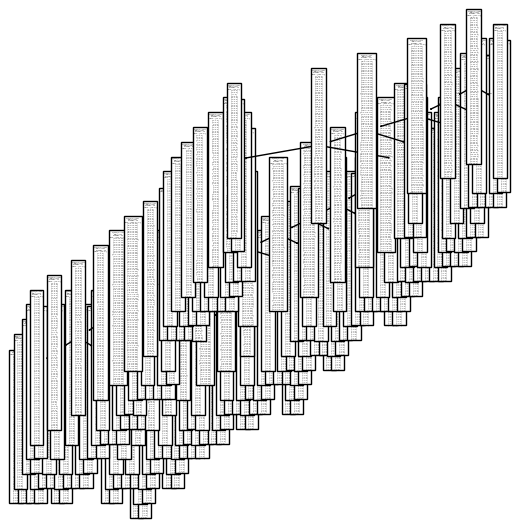

In [29]:
plot_tree(multilabel_classifier)
plt.show()

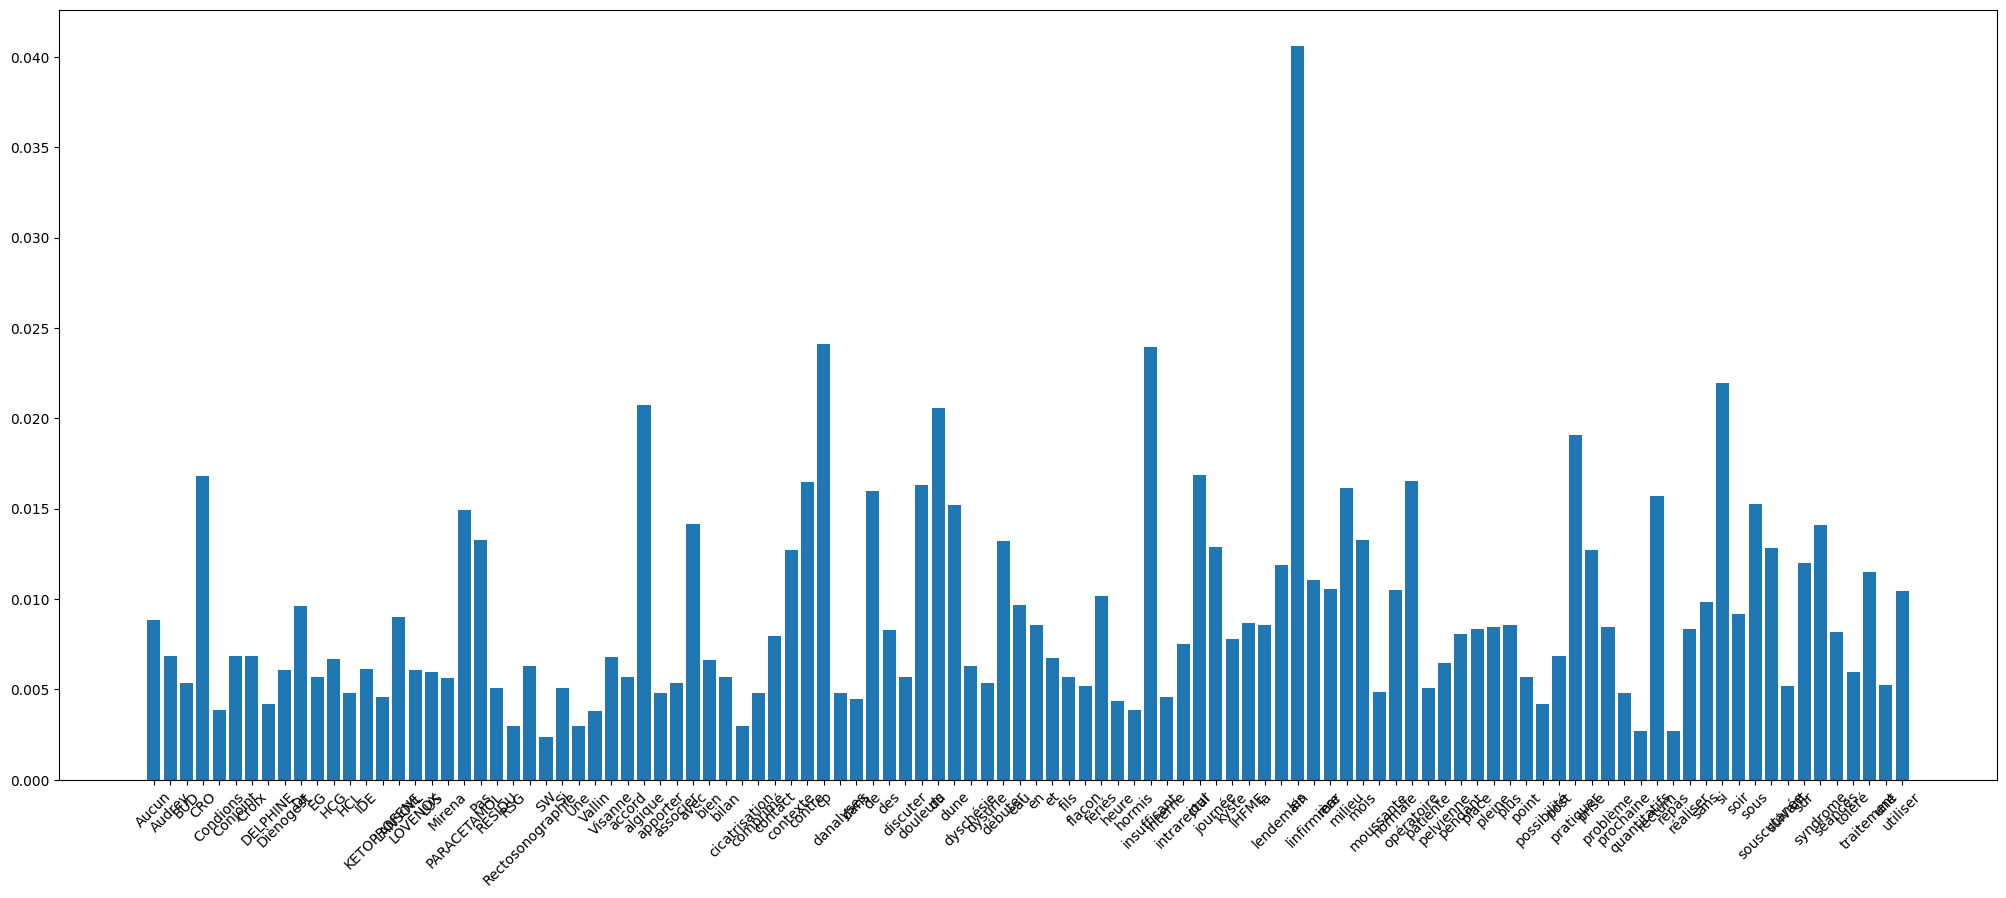

In [30]:
feature_imp = pd.Series(multilabel_classifier.feature_importances_, index=multilabel_classifier.feature_names_in_)
feature_imp_short = feature_imp.loc[feature_imp !=0]

plt.figure(figsize=(25,10))
plt.bar(list(feature_imp_short.index), list(feature_imp_short.values))
plt.xticks(rotation =45)
plt.show()

In [22]:
# eli5 not working anymore for current stable version of sklearn
eli5.explain_weights_df(multilabel_classifier, feature_names=multilabel_classifier.feature_names_in_, top=10)

AttributeError: module 'eli5' has no attribute 'explain_weights_df'

In [22]:
# eli5.show_weights(multilabel_classifier, feature_names=list(multilabel_classifier.feature_names_in_), top=10)

In [31]:
X_train_fitted_df.shape

(125, 5003)

In [32]:
Y_train.shape

(125, 85)

In [33]:
Y_pred = multilabel_classifier.predict(X_test_fitted_df)
Y_pred = pd.DataFrame(Y_pred, columns=Y_train.columns)
DT_Multi_index, CR_global = rapport_metrics_decision_tree(Y_test, Y_pred)

In [34]:
DT_Multi_index

SW           CAP            GD            JC         \
                y_true y_pred y_true y_pred y_true y_pred y_true y_pred   
Numéro anonymat                                                           
DL-178             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
NL-042             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
DL-182             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
VP-008             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
HE-072             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
NA-185             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
LB-148             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
CO-110             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
TJ-090             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
NA-126             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
BR-043             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
FE-027             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
AM-023             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
KW-085             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
VC-088             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
PG-146             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
LF-194             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
HB-158             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
RL-151             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
MC-044             0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
BN-140             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
MK-087             0.0    0.0    1.0    0.0    0.0    0.0    0.0    1.0   
DC-122             0.0    0.0    1.0    0.0    0.0    0.0    0.0    1.0   
PK-191             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
ML-170             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
GJ-018             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
QS-054             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
LS-066             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
BL-006             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
BI-180             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
CC-166             0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
RA-119             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   

                    JB         ... irm.opac.vagin        irm.opac.rectum  \
                y_true y_pred  ...         y_true y_pred          y_true   
Numéro anonymat                ...                                         
DL-178             0.0    0.0  ...              1    1.0               1   
NL-042             0.0    0.0  ...              1    1.0               1   
DL-182             0.0    0.0  ...              1    1.0               1   
VP-008             0.0    0.0  ...              1    1.0               1   
HE-072             0.0    0.0  ...              0    1.0               0   
NA-185             0.0    1.0  ...              1    1.0               0   
LB-148             0.0    0.0  ...              1    1.0               1   
CO-110             0.0    0.0  ...              1    1.0               1   
TJ-090             0.0    0.0  ...              0    1.0               0   
NA-126             0.0    0.0  ...              1    1.0               1   
BR-043             0.0    0.0  ...              1    1.0               1   
FE-027             0.0    0.0  ...              1    1.0               1   
AM-023             0.0    0.0  ...              1    1.0               1   
KW-085             0.0    0.0  ...              1    1.0               0   
VC-088             0.0    0.0  ...              1    1.0               1   
PG-146             0.0    

In [35]:
CR_global

ttt.ains    ttt.p1    sf.dsm  irm.opac.vagin    ttt.op  \
metrics f1_score_0   0.000000  0.000000  0.000000        0.000000  0.166667   
        f1_score_1   0.915254  0.915254  0.896552        0.877193  0.784314   
        f1_score_2        NaN       NaN       NaN             NaN  0.000000   
        precision_0  0.000000  0.000000  0.000000        0.000000  0.125000   
        precision_1  0.964286  0.964286  0.866667        0.862069  0.833333   
        precision_2       NaN       NaN       NaN             NaN  0.000000   
        recall_0     0.000000  0.000000  0.000000        0.000000  0.250000   
        recall_1     0.870968  0.870968  0.928571        0.892857  0.740741   
        recall_2          NaN       NaN       NaN             NaN  0.000000   

                     irm.endo  irm.opac.rectum    sf.dsp  sf.dsm.type  \
metrics f1_score_0   0.266667         0.333333  0.222222     0.000000   
        f1_score_1   0.775510         0.739130  0.711111     0.636364   
        f1_score_2        NaN              NaN  0.000000     0.000000   
        precision_0  0.666667         0.300000  0.153846     0.000000   
        precision_1  0.655172         0.772727  0.842105     0.608696   
        precision_2       NaN              NaN  0.000000     0.000000   
        recall_0     0.166667         0.375000  0.400000     0.000000   
        recall_1     0.950000         0.708333  0.615385     0.666667   
        recall_2          NaN              NaN  0.000000     0.000000   

                        ttt.p  ...        GD  effet.hormone.dig  \
metrics f1_score_0   0.105263  ...  0.984127           0.700000   
        f1_score_1   0.636364  ...  0.000000           0.000000   
        f1_score_2   0.000000  ...       NaN           0.421053   
        precision_0  0.100000  ...  0.968750           0.736842   
        precision_1  0.636364  ...  0.000000           0.000000   
        precision_2  0.000000  ...       NaN           0.363636   
        recall_0     0.111111  ...  1.000000           0.666667   
        recall_1     0.636364  ...  0.000000           0.000000   
        recall_2     0.000000  ...       NaN           0.500000   

                     ef.hormone.dpc       CAP   SW   MC  PSH   RW  aucune  \
metrics f1_score_0         0.611111  0.915254  1.0  1.0  1.0  1.0     1.0   
        f1_score_1         0.000000  0.000000  NaN  NaN  NaN  NaN     NaN   
        f1_score_2         0.421053       NaN  NaN  NaN  NaN  NaN     NaN   
        precision_0        0.611111  0.843750  1.0  1.0  1.0  1.0     1.0   
        precision_1        0.000000  0.000000  NaN  NaN  NaN  NaN     NaN   
        precision_2        0.363636       NaN  NaN  NaN  NaN  NaN     NaN   
        recall_0           0.611111  1.000000  1.0  1.0  1.0  1.0     1.0   
        recall_1           0.000000  0.000000  NaN  NaN  NaN  NaN     NaN   
        recall_2           0.500000       NaN  NaN  NaN  NaN  NaN     NaN   

                     positionnelle  
metrics f1_score_0             1.0  
        f1_score_1             NaN  
        f1_score_2             NaN  
        precision_0            1.0  
        precision_1            NaN  
        precision_2            NaN  
        recall_0               1.0  
        recall_1               NaN  
        recall_2               NaN  

[9 rows x 85 columns]

In [18]:
Y_pred.shape

(32, 85)

In [20]:
X_test_fitted_df

,AB,AC,ACIDE,ACL,ACR,ACTAEA,ACTEA,ACTITENS,ACUPAN,ADEPAL,...,éventuelle,éventuellement,évidente,évocatrice,évolution,évolutive,évoque,évoqué,événements,être
Anonymisation,,,,,,,,,,,,,,,,,,,,,
NA-144,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
AC-131,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
DS-015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
LS-066,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
LP-053,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
BC-154,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
DL-182,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
MD-108,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.060683
SM-138,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


### RFC

In [28]:
####################################################################
multilabel_classifier_RFC = RandomForestClassifier(random_state=42)
# labels_MLC = {0:'négatif', 1:'positif', 2:' Non mentionnées'}
multilabel_classifier_RFC.fit(X_train_fitted_df, Y_train)
####################################################################

RandomForestClassifier(random_state=42)

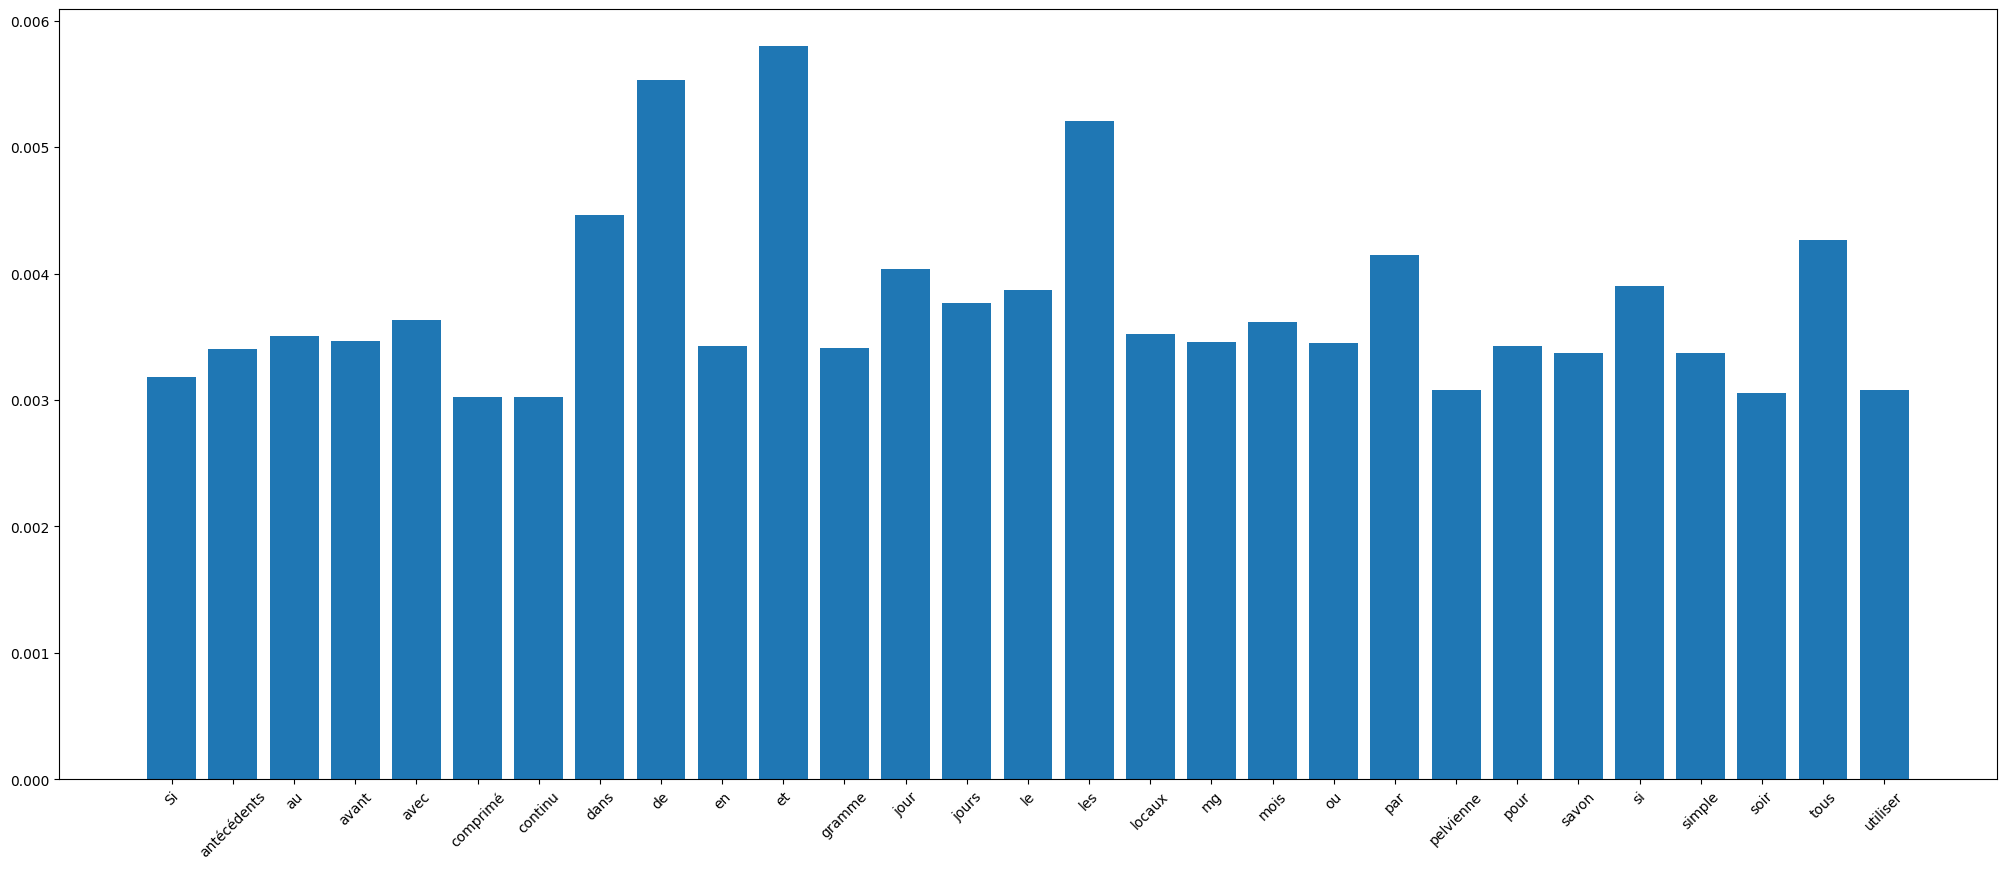

In [29]:
feature_imp_RF = pd.Series(multilabel_classifier_RFC.feature_importances_, index=multilabel_classifier_RFC.feature_names_in_)
feature_imp_RF_short = feature_imp_RF.loc[feature_imp_RF >0.003]

plt.figure(figsize=(25,10))
plt.bar(list(feature_imp_RF_short.index), list(feature_imp_RF_short.values))
plt.xticks(rotation =45)
plt.show()

In [29]:
# # df_to_transform = eli5.explain_weights_df(logregcv, vec=tfIdfVectorizer, top=6, target_names=label_temp)

# def reshape_df_explain(df_to_transform):
#     cols = list(df_to_transform)
#     rows = list(df_to_transform.index)
#     col_len = len(cols)
#     row_len = len(rows)
#     dict_ = {}
#     for row in range(row_len):
#         for col in range(col_len):        
#             dict_[f'{str(rows[row])}_{cols[col]}'] = df_to_transform.iloc[row,col]
#     return dict_

# import eli5
# from eli5.lime import TextExplainer
# from IPython.display import display

# # display(eli5.show_weights(multilabel_classifier))

# PP_test = multilabel_classifier.predict_proba(pd.DataFrame(X_test_fitted_df.iloc[0,:]).T)

# # multilabel_classifier.feature_names_in_

# def list_to_array(list_):
#     array = np.zeros(len(list_))
#     for idx, array in list_:
#         array[idx] = list_[idx]

# max_ = 0
# max_value=-1
# for array in PP_test:
#     length = len(array[0])
#     max_temp = np.max(array[0])
#     if max_<length:
#         max_ = length
#     if max_temp > max_value:
#         max_value = max_temp
# print(max_, max_value)



# array = np.zeros(2)
# print(len(array))
# array = np.pad(array, (1,0))
# array





# # eli5.show_prediction(estimator=multilabel_classifier, doc=pd.DataFrame(X_test_fitted_df.iloc[0,:]).T,
# #                     feature_names=list(X_test_fitted_df.columns),
# #                     show_feature_values=True)

# # eli5.sklearn.explain_weights.explain_decision_tree(multilabel_classifier, vec = tfIdfVectorizer)


# # eli5.explain_prediction()

# def pad_and_contract(array):
#     liste_array=[]
#     for array in array_to_pad:
#         if len(array)<=2:
#             array= list(array[0])
#             array.append(0.)
#             if len(array)<=2:
#                 array.append(0.)
                
#         liste_array.append(array)
#     return np.asarray(liste_array)

# def PP(self, doc):
#     self.transform = tfIdfVectorizer.transform(doc)
#     predicted_proba = multilabel_classifier.predict_proba(doc_fitted)
#     return pad_and_contract(array_to_pad)

# array = PP(X_test.Résumé.iloc[0])

# type(X_test.Résumé.iloc[0])

# eli5.sklearn.explain_prediction_sklearn(multilabel_classifier_RFC, X_test.Résumé.iloc[0], vec=tfIdfVectorizer)

# exp = TextExplainer(n_samples=5000, clf=multilabel_classifier, vec=tfIdfVectorizer, char_based=False,random_state=42, position_dependent=False)
# exp.fit(X_test.Résumé.iloc[0], 

# PP

# )

# eli5.sklearn.explain_weights_sklearn(multilabel_classifier, vec=tfIdfVectorizer)



# eli5.show_weights(multilabel_classifier, vec=tfIdfVectorizer)

# eli5.show_weights(multilabel_classifier, vec=tfIdfVectorizer)

In [30]:
CR_global

sf.dsm  ttt.ains    ttt.p1  irm.opac.vagin    sf.dsp  \
metrics f1_score_0      NaN  0.000000  0.000000        0.000000  0.333333   
        f1_score_1      1.0  0.967742  0.967742        0.836364  0.823529   
        f1_score_2      NaN  0.000000  0.000000             NaN  0.000000   
        precision_0     NaN  0.000000  0.000000        0.000000  1.000000   
        precision_1     1.0  1.000000  1.000000        0.766667  0.724138   
        precision_2     NaN  0.000000  0.000000             NaN  0.000000   
        recall_0        NaN  0.000000  0.000000        0.000000  0.200000   
        recall_1        1.0  0.937500  0.937500        0.920000  0.954545   
        recall_2        NaN  0.000000  0.000000             NaN  0.000000   

                       ttt.op  irm.opac.rectum     ttt.p  sf.dsm.type  \
metrics f1_score_0   0.333333         0.285714  0.352941          NaN   
        f1_score_1   0.823529         0.800000  0.782609     0.708333   
        f1_score_2   0.000000              NaN  0.000000     0.125000   
        precision_0  0.222222         0.285714  0.375000          NaN   
        precision_1  0.954545         0.800000  0.782609     0.629630   
        precision_2  0.000000              NaN  0.000000     0.200000   
        recall_0     0.666667         0.285714  0.333333          NaN   
        recall_1     0.724138         0.800000  0.782609     0.809524   
        recall_2     0.000000              NaN  0.000000     0.090909   

                       sf.dpc  ...  irm.epanchement  avis.dig/uro   GD  PSH  \
metrics f1_score_0   0.300000  ...         0.814815      0.933333  1.0  1.0   
        f1_score_1   0.697674  ...         0.000000      0.000000  NaN  NaN   
        f1_score_2   0.000000  ...              NaN           NaN  NaN  NaN   
        precision_0  0.300000  ...         0.956522      0.875000  1.0  1.0   
        precision_1  0.681818  ...         0.000000      0.000000  NaN  NaN   
        precision_2  0.000000  ...              NaN           NaN  NaN  NaN   
        recall_0     0.300000  ...         0.709677      1.000000  1.0  1.0   
        recall_1     0.714286  ...         0.000000      0.000000  NaN  NaN   
        recall_2     0.000000  ...              NaN           NaN  NaN  NaN   

                      RW  profonde post coïtale  aucune  sf.ombilic  \
metrics f1_score_0   1.0                    1.0     1.0    0.950820   
        f1_score_1   NaN                    NaN     NaN         NaN   
        f1_score_2   NaN                    NaN     NaN    0.000000   
        precision_0  1.0                    1.0     1.0    0.966667   
        precision_1  NaN                    NaN     NaN         NaN   
        precision_2  NaN                    NaN     NaN    0.000000   
        recall_0     1.0                    1.0     1.0    0.935484   
        recall_1     NaN                    NaN     NaN         NaN   
        recall_2     NaN                    NaN     NaN    0.000000   

                     spec.nodule  irm.vagin  
metrics f1_score_0      0.851852        1.0  
        f1_score_1           NaN        NaN  
        f1_score_2      0.200000        NaN  
        precision_0     0.851852        1.0  
        precision_1          NaN        NaN  
        precision_2     0.200000        NaN  
        recall_0        0.851852        1.0  
        recall_1             NaN        NaN  
        recall_2        0.200000        NaN  

[9 rows x 85 columns]

https://blog.octo.com/nlp-une-classification-multilabels-simple-efficace-et-interpretable/

In [34]:
#RandomForest, voir xgBoost

### LogisticRegressionCV

In [35]:
# Rappel des classes : 
# 0 : Negatif 
# 1 : Positif
# 2 : Données manquantes 

In [36]:
# ONE hot pas possible parce que pas assez de chir présent ....
# supprimer les chir peu présent ? donc drop des colonnes ?

In [31]:
if len(list(Y_train['PSH'].unique()))<=1:
    print('yep')
else:
    print('nope')

nope


In [36]:
# drop des colonnes uniques : 
for nom, values in Y_train.items():
    if len(list(values.unique())) <=1: 
        print(nom)
        Y_train.drop(nom, axis=1, inplace=True)

JC


In [37]:
def find_labels(liste):
    liste = pd.Series(np.unique(liste))
    liste.replace(labels_MLC, inplace=True)
    return list(liste)

In [40]:
# eli5.explain_weights_df(logregcv, feature_names=X_train_fitted_df.columns, 
#                   top=10, target_names=label_temp)

In [41]:
# display(eli5.explain_weights(logregcv, vec=tfIdfVectorizer, 
#                   top=6, target_names=label_temp))
# print(nom)
# df_to_transform = eli5.explain_weights_df(logregcv, vec=tfIdfVectorizer, top=6, target_names=label_temp)

In [42]:
# df_to_transform = eli5.explain_weights_df(logregcv, vec=tfIdfVectorizer, top=6, target_names=label_temp)
# cols = list(df_to_transform)
# rows = list(df_to_transform.index)
# col_len = len(cols)
# row_len = len(rows)
# dict_ = {}
# for row in range(row_len):
#     for col in range(col_len):        
#         dict_[f'{str(rows[row])}_{cols[col]}'] = df_to_transform.iloc[row,col]
# pd.DataFrame({'col':dict_})

In [42]:
# Nicolai: doesn't work because of eli5 incompatibility with sklearn
#CR_global_LR, LR_Multi_index, LR_y_pred, dict_model_LR = multilabel_multioutput_LR(X_train_fitted_df, X_test_fitted_df, Y_train, Y_test, tfIdfVectorizer)
#CR_global_LR.loc['metrics',:]

NameError: name 'CR_global_LR' is not defined

In [45]:
#LR_Multi_index

CAP           PSH            BC            GD         \
                y_true y_pred y_true y_pred y_true y_pred y_true y_pred   
Numéro anonymat                                                           
EM-118             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
GJ-018             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
PK-191             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
JJ-002             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
TC-195             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
NZ-184             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
NJ-001             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
HN-078             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
AM-172             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
WL-197             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
VM-156             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
HZ-196             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
LA-003             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
OA-031             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GM-160             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
GC-021             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
DM-034             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
HB-158             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
FA-086             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
AB-067             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
OE-175             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
YL-124             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
BK-143             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
VP-008             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GS-193             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
CC-019             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
BL-127             0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
FC-130             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
MC-044             0.0    0.0    0.0    0.0    1.0    1.0    0.0    0.0   
BM-011             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
TJ-090             0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
GO-037             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                    JC         ... irm.opac.vagin        irm.opac.rectum  \
                y_true y_pred  ...         y_true y_pred          y_true   
Numéro anonymat                ...                                         
EM-118             0.0    0.0  ...              1      1               0   
GJ-018             0.0    0.0  ...              1      1               1   
PK-191             0.0    0.0  ...              1      1               1   
JJ-002             0.0    0.0  ...              1      1               1   
TC-195             0.0    0.0  ...              1      1               1   
NZ-184             0.0    0.0  ...              1      1               1   
NJ-001             0.0    0.0  ...              0      1               0   
HN-078             0.0    0.0  ...              1      1               1   
AM-172             0.0    0.0  ...              0      1               0   
WL-197             0.0    0.0  ...              1      1               1   
VM-156             0.0    0.0  ...              1      1               1   
HZ-196             0.0    0.0  ...              1      1               1   
LA-003             0.0    0.0  ...              1      1               1   
OA-031             1.0    0.0  ...              1      1               1   
GM-160             0.0    0.0  ...              1      1               1   
GC-021             0.0   

In [46]:
#LR_y_pred

,CAP,PSH,BC,GD,JC,RW,MC,CJ,JB,SU,...,irm.vagin,irm.kissing,irm.adherences,irm.retroversion,irm.epanchement,irm.opac.vagin,irm.opac.rectum,irm.xr,irm.externe,avis.dig/uro
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
EM-118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
GJ-018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
PK-191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
JJ-002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
TC-195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
NZ-184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
NJ-001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
HN-078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
AM-172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [47]:
#dict_model_LR

{'CAP': LogisticRegression(),
 'PSH': LogisticRegression(),
 'BC': LogisticRegression(),
 'GD': LogisticRegression(),
 'JC': LogisticRegression(),
 'RW': LogisticRegression(),
 'MC': LogisticRegression(),
 'CJ': LogisticRegression(),
 'JB': LogisticRegression(),
 'SU': LogisticRegression(),
 nan: LogisticRegression(),
 'aucune': LogisticRegression(),
 'profonde': LogisticRegression(),
 'orificielle': LogisticRegression(),
 'profonde et orificielle': LogisticRegression(),
 'positionnelle': LogisticRegression(),
 'profonde post coïtale': LogisticRegression(),
 'profonde positionnelle': LogisticRegression(),
 'post coïtale': LogisticRegression(),
 'atcd.endo': LogisticRegression(),
 'atcd.chir.oma': LogisticRegression(),
 'atcd.fibrome': LogisticRegression(),
 'atcd.chir.endo': LogisticRegression(),
 'atcd.infertilite': LogisticRegression(),
 'atcd.pma': LogisticRegression(),
 'atcd.fiv': LogisticRegression(),
 'desir.G': LogisticRegression(),
 'atcd.sma.douleur': LogisticRegression(),
 '

### SCV 

In [3]:
CR_global_SVC, SVC_Multi_index, SVC_y_pred, dict_model_svc = multilabel_multioutput_svc(X_train_fitted_df, X_test_fitted_df, Y_train, Y_test, tfIdfVectorizer)

NameError: name 'X_train_fitted_df' is not defined

In [49]:
CR_global_SVC, SVC_Multi_index, SVC_y_pred, dict_model_svc = multilabel_multioutput_svc(X_train_fitted_df, X_test_fitted_df, Y_train, Y_test, tfIdfVectorizer)

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\de

done


C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:
CR_global_SVC

ttt.p1        sf.dsm irm.opac.vagin  ttt.ains  \
0       feature           NaN        <BIAS>         <BIAS>       NaN   
        target            NaN             0              1       NaN   
        weight            NaN      0.867479       0.892312       NaN   
1       feature           NaN          ordo           chir       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.256309       -0.35406       NaN   
2       feature           NaN  probablement        jusquau       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.268831       -0.36892       NaN   
3       feature           NaN      syndrome         règles       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.299663      -0.400767       NaN   
4       feature           NaN     démarrage       ANDROCUR       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.320188      -0.484526       NaN   
5       feature           NaN          chir     prochaines       NaN   
        target            NaN             0              1       NaN   
        weight            NaN      -0.38014      -0.522002       NaN   
metrics f1_score_0   0.000000           0.0            0.0   0.00000   
        f1_score_1   0.984127      0.984127        0.95082   0.95082   
        f1_score_2        NaN           NaN            NaN       NaN   
        precision_0  0.000000           0.0            0.0   0.00000   
        precision_1  0.968750       0.96875        0.90625   0.90625   
        precision_2       NaN           NaN            NaN       NaN   
        recall_0     0.000000           0.0            0.0   0.00000   
        recall_1     1.000000           1.0            1.0   1.00000   
        recall_2          NaN           NaN            NaN       NaN   

                       ttt.op    sf.dsp irm.opac.rectum     irm.endo  \
0       feature           NaN       NaN          <BIAS>       <BIAS>   
        target            NaN       NaN               1            0   
        weight            NaN       NaN        0.774648     0.741124   
1       feature           NaN       NaN            chir  prélèvement   
        target            NaN       NaN               1            0   
        weight            NaN       NaN       -0.445956     -0.43283   
2       feature           NaN       NaN        ANDROCUR    PHARMACIE   
        target            NaN       NaN               1            0   
        weight            NaN       NaN       -0.484526    -0.442534   
3       feature           NaN       NaN      prochaines        carte   
        target            NaN       NaN               1            0   
        weight            NaN       NaN       -0.522002    -0.445246   
4       feature           NaN       NaN            jour     ANDROCUR   
        target            NaN       NaN               1            0   
        weight            NaN       NaN       -0.637101    -0.484526   
5       feature           NaN       NaN             gel      capsule   
        target            NaN       NaN               1            0   
        weight            NaN       NaN       -0.679845    -0.564716   
metrics f1_score_0   0.000000  0.000000             0.0          0.0   
        f1_score_1   0.896552  0.877193        0.877193     0.877193   
        f1_score_2   0.000000  0.000000             NaN          NaN   
        precision_0  0.000000  0.000000             0.0          0.0   
        precision_1  0.812500  0.781250         0.78125      0.78125   
        precision_2  0.000000  0.000000             NaN          NaN   
        recall_0     0.000000  0.000000             0.0          0.0   
        recall_1     1.000000  1.000000             1.0          1.0   
        recall_2     0.000000  0.000000             NaN       

In [51]:
for nom in Y_train.columns:
    print(nom)
    custom_show_weights(dict_model_LR, tfIdfVectorizer, nom)

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CAP


PSH


BC


GD


JC


RW


MC


CJ


JB


SU


nan


aucune


profonde


orificielle


profonde et orificielle


positionnelle


profonde post coïtale


profonde positionnelle


post coïtale


atcd.endo


atcd.chir.oma


atcd.fibrome


atcd.chir.endo


atcd.infertilite


atcd.pma


atcd.fiv


desir.G


atcd.sma.douleur


atcd.hospit.douleur


atcd.absenteisme


ttt.op


ttt.p


ttt.ains


ttt.p1


ttt.p2


ttt.p3


sf.dsm


sf.dsm.type


sf.dpc


sf.dsp


sf.dig.diarrhee


sf.dig.constip


sf.dig.rectorragie


sf.uro


sf.scap


sf.ombilic


effet.hormone


ef.hormone.dsp


ef.hormone.dsm


ef.hormone.dpc


effet.hormone.dig


tv.douloureux


tv.douleur.lusd


tv.douleur.lusg


tv.douleur.torus


tv.nodule.lusd


tv.nodule.lusg


tv.nodule.torus


spec.nodule


echo.oma


echo.adm


echo.noduleRV


echo.lusd


echo.lusg


echo.torus


echo.rectum


echo.sigmoide


irm.endo


irm.adm


irm.lusd


irm.lusg


irm.torus


irm.oma


irm.dig


irm.vagin


irm.kissing


irm.adherences


irm.retroversion


irm.epanchement


irm.opac.vagin


irm.opac.rectum


irm.xr


irm.externe


avis.dig/uro


In [52]:
CR_global_SVC.loc['metrics',:]

,ttt.p1,sf.dsm,irm.opac.vagin,ttt.ains,ttt.op,sf.dsp,irm.opac.rectum,irm.endo,ttt.p,sf.dsm.type,...,CJ,JB,aucune,orificielle,positionnelle,profonde post coïtale,profonde positionnelle,sf.ombilic,echo.noduleRV,irm.vagin
f1_score_0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95082,0.933333,1.0
f1_score_1,0.984127,0.984127,0.95082,0.95082,0.896552,0.877193,0.877193,0.877193,0.814815,0.792453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1_score_2,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN
precision_0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.90625,0.875000,1.0
precision_1,0.968750,0.96875,0.90625,0.90625,0.812500,0.781250,0.78125,0.78125,0.687500,0.656250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision_2,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN
recall_0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,1.0
recall_1,1.000000,1.0,1.0,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall_2,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN


## NLP avec correction : 

In [14]:
# Préprocess les datas :
X_train_corr, X_test_corr, Y_train, Y_test, max_vocab = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    'all',
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=True,      # supprime les caractères spéciaux
                                                                    accents=True,    # supprime les accents
                                                                    lower=False,            # passe la casse du texte en minuscule
                                                                    token=False,            # tokenize le corpus
                                                                    remove_stopwords=False,
                                                                    drop_number=True,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True,
                                                                    correction=True
                                                                  )
print(f'Nombre de patientes inclues dans l\'étude NLP "baseline" : {X_train.shape[0] + X_test.shape[0]}')
print(f'Nombre de symptômes/caractéristiques à prédire dans l\'étude NLP "Correction" : {Y_train.shape[1]}')

Nombre de patientes inclues dans l'étude NLP "baseline" : 157
Nombre de symptômes/caractéristiques à prédire dans l'étude NLP "Correction" : 85


In [16]:
# drop des colonnes uniques : 
for nom, values in Y_train.items():
    if len(list(values.unique())) <=1: 
        print(nom)
        Y_train.drop(nom, axis=1, inplace=True)

In [17]:
#max_vocab = 25000
tfIdfVectorizer_corr = TfidfVectorizer(use_idf=True, max_features=max_vocab, lowercase=False)
X_train_corr_fitted = tfIdfVectorizer_corr.fit_transform(X_train_corr.Résumé)
X_train_corr_fitted_df = pd.DataFrame(X_train_corr_fitted.todense(), columns=tfIdfVectorizer_corr.get_feature_names_out(), index= X_train.Anonymisation)
X_test_corr_fitted = tfIdfVectorizer_corr.transform(X_test.Résumé)
X_test_corr_fitted_df = pd.DataFrame(X_test_corr_fitted.todense(), columns=tfIdfVectorizer_corr.get_feature_names_out(), index= X_test.Anonymisation)

In [18]:
CR_global_SVC_corr, SVC_Multi_index_corr, SVC_y_pred_corr, dict_model_svc_corr = multilabel_multioutput_svc(X_train_corr_fitted_df, X_test_corr_fitted_df, Y_train, Y_test, tfIdfVectorizer_corr)

NameError: name 'eli5' is not defined

In [57]:
CR_global_LR_corr, LR_Multi_index_corr, LR_y_pred_corr, dict_model_LR_corr = multilabel_multioutput_LR(X_train_corr_fitted_df, X_test_corr_fitted_df, Y_train, Y_test, tfIdfVectorizer_corr)

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\de

done


C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
CR_global_SVC_corr

ttt.p1        sf.dsm irm.opac.vagin  ttt.ains  \
0       feature           NaN        <BIAS>         <BIAS>       NaN   
        target            NaN             0              1       NaN   
        weight            NaN      0.862975       0.899358       NaN   
1       feature           NaN          chir        jusquau       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.288798      -0.372876       NaN   
2       feature           NaN     démarrage         règles       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.315385      -0.408967       NaN   
3       feature           NaN           spc   métrorragies       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.315385       -0.41516       NaN   
4       feature           NaN          séro       androcur       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.315385      -0.487268       NaN   
5       feature           NaN  prémenstruel     prochaines       NaN   
        target            NaN             0              1       NaN   
        weight            NaN     -0.418239      -0.526372       NaN   
metrics f1_score_0   0.000000           0.0            0.0   0.00000   
        f1_score_1   0.984127      0.984127        0.95082   0.95082   
        f1_score_2        NaN           NaN            NaN       NaN   
        precision_0  0.000000           0.0            0.0   0.00000   
        precision_1  0.968750       0.96875        0.90625   0.90625   
        precision_2       NaN           NaN            NaN       NaN   
        recall_0     0.000000           0.0            0.0   0.00000   
        recall_1     1.000000           1.0            1.0   1.00000   
        recall_2          NaN           NaN            NaN       NaN   

                       ttt.op irm.opac.rectum     irm.endo    sf.dsp  \
0       feature           NaN          <BIAS>       <BIAS>       NaN   
        target            NaN               1            0       NaN   
        weight            NaN        0.774601     0.727739       NaN   
1       feature           NaN        lamaline   prochaines       NaN   
        target            NaN               1            0       NaN   
        weight            NaN       -0.522449    -0.418618       NaN   
2       feature           NaN      prochaines        carte       NaN   
        target            NaN               1            0       NaN   
        weight            NaN       -0.526372    -0.440349       NaN   
3       feature           NaN          essure     androcur       NaN   
        target            NaN               1            0       NaN   
        weight            NaN       -0.558785    -0.487268       NaN   
4       feature           NaN            jour      capsule       NaN   
        target            NaN               1            0       NaN   
        weight            NaN       -0.686366    -0.560874       NaN   
5       feature           NaN             gel  prélèvement       NaN   
        target            NaN               1            0       NaN   
        weight            NaN       -0.757822    -0.570764       NaN   
metrics f1_score_0   0.000000             0.0          0.0  0.000000   
        f1_score_1   0.896552        0.877193     0.877193  0.857143   
        f1_score_2   0.000000             NaN          NaN  0.000000   
        precision_0  0.000000             0.0          0.0  0.000000   
        precision_1  0.812500         0.78125      0.78125  0.774194   
        precision_2  0.000000             NaN          NaN  0.000000   
        recall_0     0.000000             0.0          0.0  0.000000   
        recall_1     1.000000             1.0          1.0  0.960000   
        recall_2     0.000000             NaN          NaN  0.

In [59]:
CR_global_LR_corr

sf.dsm        ttt.p1      ttt.ains irm.opac.vagin  \
0       feature            <BIAS>  prémenstruel  prémenstruel         <BIAS>   
        target                  0           1.0           1.0              1   
        weight           2.536635      0.347072      0.328139       1.797876   
1       feature           pendant      syndrome      syndrome        jusquau   
        target                  0           1.0           1.0              1   
        weight           0.268116      0.293295      0.295438      -0.316815   
2       feature         démarrage           spc      patiente         règles   
        target                  0           1.0           1.0              1   
        weight          -0.267186      0.259511      0.293766      -0.346475   
3       feature               spc          séro          nous       androcur   
        target                  0           1.0           1.0              1   
        weight          -0.267186      0.259511       0.26481       -0.36067   
4       feature              séro     démarrage       pendant             de   
        target                  0           1.0           1.0              1   
        weight          -0.267186      0.259511     -0.288466      -0.362424   
5       feature      prémenstruel        <BIAS>        <BIAS>     prochaines   
        target                  0           1.0           1.0              1   
        weight          -0.362319     -0.636196     -0.334015      -0.391409   
metrics f1_score_0            0.0           0.0           0.0            0.0   
        f1_score_1       0.984127      0.984127       0.95082        0.95082   
        f1_score_2            NaN           NaN           NaN            NaN   
        precision_0           0.0           0.0           0.0            0.0   
        precision_1       0.96875       0.96875       0.90625        0.90625   
        precision_2           NaN           NaN           NaN            NaN   
        recall_0              0.0           0.0           0.0            0.0   
        recall_1              1.0           1.0           1.0            1.0   
        recall_2              NaN           NaN           NaN            NaN   

                        ttt.op     irm.endo     sf.dsp irm.opac.rectum  \
0       feature         essure       <BIAS>   comprimé          <BIAS>   
        target             1.0            0        2.0               1   
        weight        0.407471     1.265284   0.442021        1.243599   
1       feature           sans        faire         du              cp   
        target             1.0            0        2.0               1   
        weight        0.344924     0.352402   0.430314       -0.339546   
2       feature      référence      capsule      cycle        lamaline   
        target             1.0            0        2.0               1   
        weight        0.280371     -0.32457   0.376161       -0.350777   
3       feature            pas        carte        gel          essure   
        target             1.0            0        2.0               1   
        weight       -0.259991    -0.338047   0.369129       -0.363679   
4       feature           fils           un  duphaston             gel   
        target             1.0            0        2.0               1   
        weight        -0.26967    -0.342068   0.286083       -0.476124   
5       feature       ablation  prélèvement         de            jour   
        target             1.0            0        2.0               1   
        weight       -0.274699    -0.365693  -0.366747       -0.627018   
metrics f1_score_0         0.0          0.0        0.0             0.0   
        f1_score_1    0.896552     0.877193   0.877193        0.877193   
        f1_score_2         0.0          NaN        0.0             NaN   
        precision_0        0.0          0.0        0.0             0.0   
        precision_1     0.8125      0.78125    0.78125         0.78125   
        pr

## LSTM

In [2]:
recueil

NameError: name 'recueil' is not defined

In [11]:
X_train2, X_test2, Y_train2, Y_test2, max_vocab2 = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=False,     # supprime les caractères spéciaux  
                                                                    lower=False,            # passe la casse du texte en minuscule
                                                                    token=False,            # tokenize le corpus
                                                                    remove_stopwords=False,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True
                                                                  )
X_val2 = X_train2.iloc[117:,:]
Y_val = Y_train2.iloc[117:,:]
X_train2 = X_train2.iloc[:117,:]
Y_train2 = Y_train2.iloc[:117,:]
# Sauvegarder les files pour pouvoir les réouvrir et repartir d'ici !!!!!!

In [8]:
max_vocab_size = max_vocab2 

tokenizer = Tokenizer(num_words=max_vocab_size, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(pd.concat([X_train2,X_val2]).loc[:,'Résumé'])

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
train_seqs = tokenizer.texts_to_sequences(X_train2.loc[:,'Résumé'])
valid_seqs = tokenizer.texts_to_sequences(X_val2.loc[:,'Résumé'])
test_seqs = tokenizer.texts_to_sequences(X_test2.loc[:,'Résumé'])

In [63]:
# # We need to pad the sequences so that they are all the same length :
# # the length of the longest one
# max_seq_length = max( [len(seq) for seq in train_seqs + valid_seqs] )

# X_train_pad = pad_sequences(train_seqs, max_seq_length)
# X_valid_pad = pad_sequences(valid_seqs, max_seq_length)
# X_test_pad = pad_sequences(test_seqs, max_seq_length)

# def get_lstm_model_2(vocab_size, embedding_dim, seq_length, lstm_out_dim, dropout_rate, n_dense=99):
#     model = Sequential()
#     model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length))
#     model.add(LSTM(units=lstm_out_dim))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='sigmoid'))
    
#     # NE PAS OUBLIER DE DEFINIR LA METRIQUE !!!!!
#     model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', 'Recall'])
#     return model

# embedding_dim = 100
# lstm_out_dim = 200
# dropout_rate = 0.2

# model = get_lstm_model_2(max_vocab_size, embedding_dim, max_seq_length, lstm_out_dim, dropout_rate)
# # print(model.summary())
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
# batch_size = 64
# max_epochs = 10
# history = model.fit(X_train_pad, Y_train2, epochs=max_epochs, batch_size=batch_size, 
#                     verbose=0, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])
    

In [64]:
       
# # Définir la metrique dans le .compile !!!!!
# test_acc = model.evaluate(X_test2, Y_test2, verbose=0)     